# A first example
This is a first example of how to use lettuce.
A two dimensional Taylor Green vortex is initialized and simulated for 10000 steps. Afterwards the energy and the velocity field is plotted.

In [6]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

In [7]:
context = lt.Context(device=torch.device('cuda:0') if torch.cuda
                     .is_available() else torch.device('cpu'),
                     dtype=torch.float32, use_native = False)
flow = lt.SuperReducedTaylorGreenVortex3D(resolution=40,reynolds_number=100,
                            mach_number=0.1, stencil=lt.D3Q27,
                            context=context)
collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu)
energyreporter = lt.ObservableReporter(lt.IncompressibleKineticEnergy(flow), interval=100, out=None)
simulation = lt.SimulationReducedTGV(flow=flow, collision=collision, reporter=[energyreporter])

steps     time     IncompressibleKineticEnergy
[[(2, 1), (12, 13), (14, 11), (16, 17), (18, 15), (20, 25), (22, 23), (24, 21), (26, 19)], [(4, 3), (8, 9), (10, 7), (16, 18), (17, 15), (20, 24), (22, 26), (23, 19), (25, 21)], [(5, 6), (7, 9), (10, 8), (11, 13), (14, 12), (19, 21), (22, 20), (23, 25), (26, 24)], [(6, 5), (8, 14), (9, 11), (12, 10), (13, 7), (20, 22), (21, 19), (24, 23), (25, 26)], [(1, 4), (11, 10), (13, 8), (15, 17), (17, 16), (19, 23), (21, 25), (23, 22), (25, 20)], [(3, 2), (7, 14), (9, 12), (15, 18), (18, 16), (19, 26), (21, 24), (24, 20), (26, 22)]]


* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

## Run simulation

In [8]:
mlups = simulation(1)

print("Performance in MLUPS:", mlups)

print(flow.u_pu)

ich wurde gecalled
tensor([[[[ 9.0524e-02,  2.5064e-02,  4.4171e-02,  ...,  4.8997e-01,
            4.9152e-01,  4.0504e-01],
          [ 9.2093e-02,  2.5200e-02,  4.4378e-02,  ...,  4.8797e-01,
            4.8950e-01,  4.0532e-01],
          [ 9.1780e-02,  2.5111e-02,  4.4229e-02,  ...,  4.8639e-01,
            4.8792e-01,  4.0401e-01],
          ...,
          [ 4.3093e-03, -8.0538e-04,  1.0299e-03,  ...,  3.7067e-02,
            3.7170e-02,  2.9948e-02],
          [ 6.5688e-04, -1.9345e-03, -8.4957e-04,  ...,  1.7935e-02,
            1.7979e-02,  1.4113e-02],
          [ 2.9812e-02,  6.9771e-03,  1.4037e-02,  ...,  1.8106e-01,
            1.8165e-01,  1.4982e-01]],

         [[ 7.8593e-03, -5.8312e-04, -9.6546e-04,  ..., -8.5376e-03,
           -8.5597e-03, -1.7292e-02],
          [ 9.6203e-03,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00, -9.9647e-03],
          [ 9.5905e-03,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00, -9.9340e-03],
 

## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(2, 3)


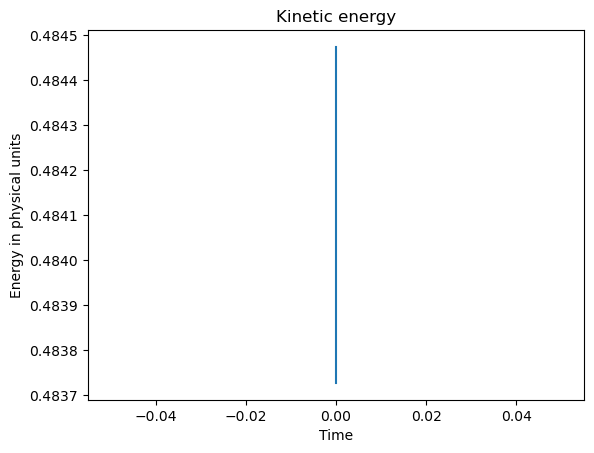

In [9]:
energy = np.array(simulation.reporter[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

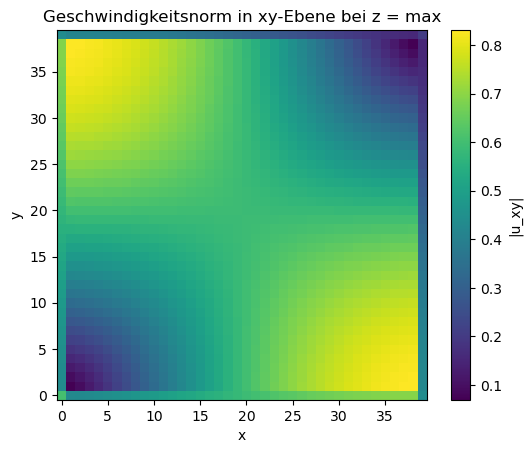

In [10]:
u = flow.u_pu.cpu().numpy()
# Slice bei z = -1
ux = u[0, :, :, -1]
uy = u[1, :, :, -1]

# Norm der xy-Geschwindigkeit (ohne uz)
u_xy_norm = np.sqrt(ux**2 + uy**2)

# Plot
plt.imshow(u_xy_norm.T, origin='lower', cmap='viridis')
plt.colorbar(label='|u_xy|')
plt.title('Geschwindigkeitsnorm in xy-Ebene bei z = max')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
